# Milestone Project 2: SkimLit

## Get Data

In [1]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
!ls pubmed-rct

PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

import os
file_names = [data_dir + '/'+ i for i in os.listdir(data_dir)]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess Data

In [4]:
def get_lines(filename):
  ls = []
  dic = {
      'code': [],
      'target' : [],
      'lines' : [],
        }
  with open(filename, 'r') as f:
    for i in f.readlines():
      if i != '\n':
        if i[:3] == '###':
          dic['code'] *= len(dic['target'])
          ls.append(dic)
          dic = {
              'code': [],
              'target' : [],
              'lines' : [],
                }
          dic['code'].append(i[3:].strip())
        else:
          # global sequence
          sequence = i.split('\t')
          dic['target'].append(sequence[0])
          dic['lines'].append(*sequence[1:])
  return ls[1:]

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [8]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 849 ms, sys: 107 ms, total: 956 ms
Wall time: 1.34 s


(180040, 30212, 30135)

In [9]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [10]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

## Model 0: BaseLine

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [14]:
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.7218323844829869

In [15]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [16]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-11-13 06:53:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-13 06:53:22 (69.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [17]:
from helper_functions import *

In [18]:
baseline_results = calculate_results(
    y_true= val_labels_encoded,
    y_pred= baseline_preds
)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Vectorization and Embedings:

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [20]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len, np.max(sent_lens), sum(np.array(sent_lens) > 100), len(sent_lens), \
np.percentile(sent_lens,95)

(26.338269273494777, 296, 525, 180040, 55.0)

In [21]:
from tensorflow.keras.layers import TextVectorization
max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length = int(np.percentile(sent_lens,95)))

In [22]:
text_vectorizer.adapt(train_sentences)

In [23]:
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of Text:\n{len(target_sentence.split())}')
print(f'\nVectorized Text:\n{text_vectorizer(target_sentence)}')
print(f'\nVectorized Text:\n{len(text_vectorizer(target_sentence))}')

Text:
at the end of the treatment period , significantly fewer patients had lost weight in the intervention group ( mean : @ % vs. @ % , p < @ ) , and the fulfillment of estimated energy requirements was better during treatment ( mean : @ % vs. @ % , p < @ ) .

Length of Text:
57

Vectorized Text:
[   15     2   199     4     2    19   173    39   704    12    55  1499
   174     5     2    38    13    57    44    14     3     2 23086     4
   597   756  1953    10   252    52    19    57    44    14     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

Vectorized Text:
55


In [24]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [25]:
from tensorflow.keras.layers import Embedding
embed = Embedding(input_dim=len(rct_20k_text_vocab),
                     output_dim = 128,
                     mask_zero=True)

## Creating Datasets (Data pipeline)

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences,train_labels_one_hot)
    )

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences,val_labels_one_hot)
    )

test_dataset = tf.data.Dataset.from_tensor_slices(
    (
        test_sentences,
        test_labels_one_hot
    )
)

In [27]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D

In [28]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)

text_vectors = text_vectorizer(inputs)

embedings = embed(text_vectors)

x = layers.Conv1D(64, kernel_size=5, padding='same',activation='relu')(embedings)

x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(5,activation='softmax')(x)

model_1 = tf.keras.Model(inputs,outputs)

model_1.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_1.fit(train_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_dataset)),
            validation_data = valid_dataset,
            validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 72s 126ms/step - loss: 0.9169 - accuracy: 0.6343 - val_loss: 0.6917 - val_accuracy: 0.7367
Epoch 2/3
562/562 [==============================] - 69s 122ms/step - loss: 0.6661 - accuracy: 0.7527 - val_loss: 0.6414 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 68s 121ms/step - loss: 0.6270 - accuracy: 0.7700 - val_loss: 0.6028 - val_accuracy: 0.7839


In [29]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 325   

In [30]:
model_1.evaluate(valid_dataset), model_1.evaluate(test_dataset)

942/942 [==============================] - 6s 6ms/step - loss: 0.6199 - accuracy: 0.7776


([0.6076226234436035, 0.7822057604789734],
 [0.6198621988296509, 0.7776339650154114])

In [31]:
model_1_preds_prob = model_1.predict(valid_dataset)
model_1_preds = tf.argmax(model_1_preds_prob,axis=1)

945/945 [==============================] - 5s 5ms/step


In [32]:
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_preds)

In [33]:
model_1_results

{'accuracy': 78.22057460611677,
 'precision': 0.7792276271592941,
 'recall': 0.7822057460611678,
 'f1': 0.7801649060792869}

##Model 2: TensorHub

In [34]:

# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [35]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the most common grade @/@ adverse events included neutropenia ( @ % versus @ % ) , fatigue ( @ % versus @ % ) , and hypertension ( @ % versus @ % ) .

Sentence after embedding:
[-0.03296991 -0.04488518  0.01771464 -0.01769941 -0.00111132  0.05371508
  0.04643035 -0.04452096  0.0104255   0.04947385  0.06833026  0.04443562
  0.03341184 -0.05242606 -0.03460378 -0.01868589 -0.07975686  0.02000298
 -0.00659596 -0.03077754  0.08542687  0.0076068  -0.07717672 -0.01638379
  0.052031   -0.0134468  -0.05895581  0.0033726   0.02373112  0.03882205] (truncated output)...

Length of sentence embedding:
512


In [36]:
inputs = layers.Input(shape=[], dtype=tf.string)

pretrained_embedding = tf_hub_embedding_layer(inputs)

x = layers.Dense(128, activation='relu')(pretrained_embedding)

outputs = layers.Dense(5, activation='softmax')(x)


model_2 = tf.keras.Model(inputs,outputs)


model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data = valid_dataset,
    validation_steps = int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9137 - accuracy: 0.6506 - val_loss: 0.7972 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7707 - accuracy: 0.7009 - val_loss: 0.7576 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7554 - accuracy: 0.7110 - val_loss: 0.7423 - val_accuracy: 0.7131


In [37]:
model_2_preds_prob = model_2.predict(valid_dataset)
model_2_preds = tf.argmax(model_2_preds_prob,axis=1)

945/945 [==============================] - 13s 13ms/step


In [38]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_preds)
model_2_results

{'accuracy': 71.15715609691513,
 'precision': 0.7119079919371284,
 'recall': 0.7115715609691513,
 'f1': 0.7086457644968829}

## Model 3: Conv1D with character embeddings

### Creating Character-level tokenizer

In [39]:
' '.join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [40]:
def split_chars(text):
  return ' '.join(list(text))

In [41]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [42]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
output_seq_char_len = np.percentile(char_lens,95)
mean_char_len,output_seq_char_len

(149.3662574983337, 290.0)

In [43]:
# get all keyboard characters
import string

alphabet = string.ascii_lowercase + string.digits #+ string.punctuation

NUM_CHAR_TOKENS = len(alphabet) + 2

char_vectorizer = TextVectorization(
    max_tokens = NUM_CHAR_TOKENS,
    output_sequence_length = int(output_seq_char_len),
    standardize='lower_and_strip_punctuation',
    name='char_vectorizer'
)

In [44]:
char_vectorizer.adapt(train_chars)

In [45]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [46]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
o r a l   d y d r o g e s t e r o n e   a p p e a r s   t o   b e   e q u a l l y   e f f e c t i v e   i n   i m p r o v i n g   e n d o m e t r i a l   b l o o d   f l o w   a s   c o m p a r e d   w i t h   m i c r o n i z e d   p r o g e s t e r o n e   .

Length of chars: 113

Vectorized chars:
[[ 7  8  5 12 10 19 10  8  7 18  2  9  3  2  8  7  6  2  5 14 14  2  5  8
   9  3  7 22  2  2 26 16  5 12 12 19  2 17 17  2 11  3  4 21  2  4  6  4
  15 14  8  7 21  4  6 18  2  6 10  7 15  2  3  8  4  5 12 22 12  7  7 10
  17 12  7 20  5  9 11  7 15 14  5  8  2 10 20  4  3 13 15  4 11  8  7  6
   4 25  2 10 14  8  7 18  2  9  3  2  8  7  6  2  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

In [47]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")


Charified text (before vectorization and embedding):
o r a l   d y d r o g e s t e r o n e   a p p e a r s   t o   b e   e q u a l l y   e f f e c t i v e   i n   i m p r o v i n g   e n d o m e t r i a l   b l o o d   f l o w   a s   c o m p a r e d   w i t h   m i c r o n i z e d   p r o g e s t e r o n e   .

Embedded chars (after vectorization and embedding):
[[[-0.02115022 -0.02904063  0.01496312 ... -0.02489489  0.04888734
   -0.02010331]
  [-0.02269496  0.04960005  0.0204859  ...  0.04132732 -0.02192104
    0.04488233]
  [ 0.04255104  0.03355244  0.01367098 ... -0.03916752  0.03927134
    0.04144526]
  ...
  [-0.03623507  0.01136087 -0.00853527 ...  0.04835076 -0.0344077
    0.01824495]
  [-0.03623507  0.01136087 -0.00853527 ...  0.04835076 -0.0344077
    0.01824495]
  [-0.03623507  0.01136087 -0.00853527 ...  0.04835076 -0.0344077
    0.01824495]]]

Character embedding shape: (1, 290, 25)


In [48]:
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = char_vectorizer(inputs)

x = char_embed(x)

x = layers.Conv1D(128,25,padding='same',activation='relu')(x)

x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs,outputs)

model_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [49]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           950       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 128)          80128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 645 

In [50]:

# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [51]:
model_3.fit(
    train_char_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    validation_data= val_char_dataset,
    validation_steps= int(0.1*len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 67s 119ms/step - loss: 1.1484 - accuracy: 0.5356 - val_loss: 0.9070 - val_accuracy: 0.6516
Epoch 2/3
562/562 [==============================] - 66s 117ms/step - loss: 0.8754 - accuracy: 0.6616 - val_loss: 0.7968 - val_accuracy: 0.7001
Epoch 3/3
562/562 [==============================] - 69s 123ms/step - loss: 0.7995 - accuracy: 0.6962 - val_loss: 0.7492 - val_accuracy: 0.7168


In [52]:

# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 31s 33ms/step


array([[0.25770682, 0.37950686, 0.04840127, 0.28501916, 0.02936589],
       [0.15461984, 0.43232834, 0.019246  , 0.34899512, 0.04481081],
       [0.05603174, 0.02804253, 0.01106047, 0.90300554, 0.00185971],
       ...,
       [0.00880965, 0.02540565, 0.04167081, 0.00913667, 0.9149772 ],
       [0.04996964, 0.3532744 , 0.164894  , 0.09669677, 0.33516517],
       [0.15295203, 0.80333436, 0.02204918, 0.01902176, 0.00264261]],
      dtype=float32)

In [53]:

# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 1, 1])>

In [54]:

# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 70.34291010194625,
 'precision': 0.7075343855730704,
 'recall': 0.7034291010194624,
 'f1': 0.6922457913452974}

In [55]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embedding


In [151]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(256,activation = 'relu')(token_embeddings)

token_model = tf.keras.Model(token_inputs,token_outputs)


# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)

char_model = tf.keras.Model(char_inputs,char_bi_lstm)


# 3. Concatenate token char inputs
token_char_concatenate = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                       char_model.output])

# 4. Create output layers - adding Dropout
combined_dropout = layers.Dropout(0.4)(token_char_concatenate)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.4)(combined_dense)
output_layer = layers.Dense(5, activation='softmax')(final_dropout)


# Creating The Final Model
model_4 = tf.keras.Model(
    inputs= [token_model.input, char_model.input],
    outputs= output_layer
)



ValueError: ignored

In [57]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

In [58]:
from keras.utils import plot_model

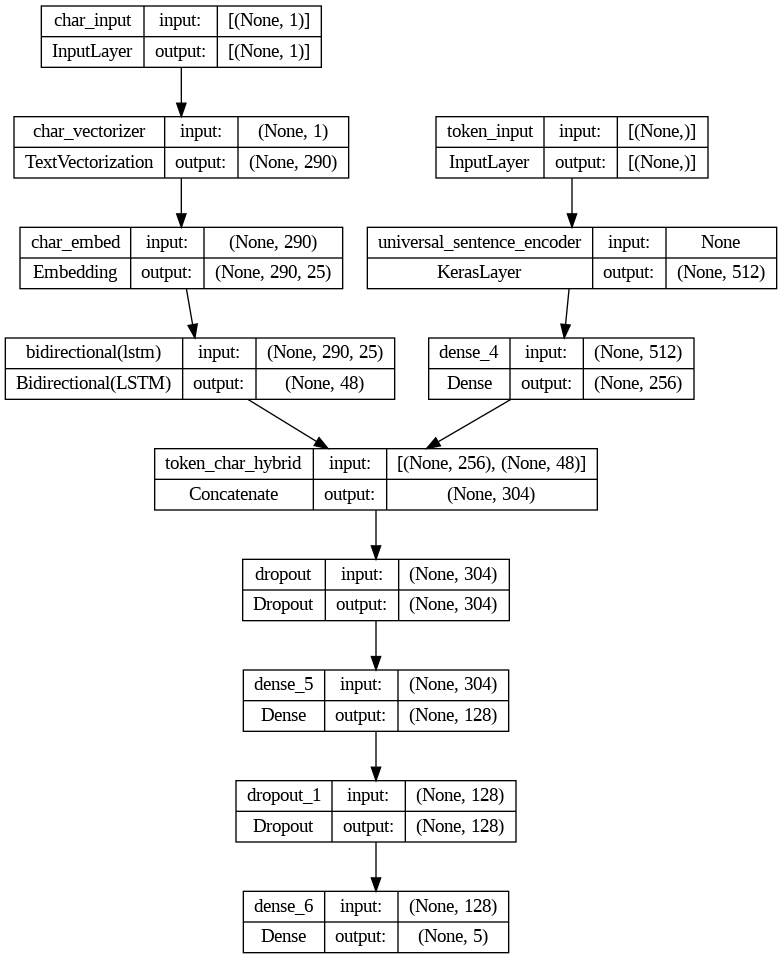

In [59]:
plot_model(model_4,show_shapes=True)

In [60]:
model_4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [61]:
train_char_token_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)
)

train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_dataset = tf.data.Dataset.zip(train_char_token_data,train_char_token_labels)

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



val_char_token_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_chars)
)

val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip(val_char_token_data,val_char_token_labels)

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [62]:
model_4.fit(
    train_char_token_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_char_token_data)),
    validation_data = val_char_token_dataset,
    validation_steps= int(0.1*len(val_char_token_dataset)),
)

Epoch 1/3
 1816/18004 [==>...........................] - ETA: 58:34 - loss: 0.7936 - accuracy: 0.6936

KeyboardInterrupt: ignored

## Model 5: += Positional Embedding

### Create Positional embeddings

In [63]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [67]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [171]:
test_df.head()

,target,text,line_number,total_lines,engineering
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,0 %
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,20 %
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,30 %
3,RESULTS,survival analyses were used to assess the asso...,3,8,40 %
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,50 %


In [174]:
def map_eng(x):
  if x == 0:
    return 0
  elif x > 0 and x <= 0.1:
    return 1
  elif x > 0.1 and x <= 0.2:
    return 2
  elif x > 0.2 and x <= 0.3:
    return 3
  elif x > 0.3 and x <= 0.4:
    return 4
  elif x > 0.4 and x <= 0.5:
    return 5
  elif x > 0.5 and x <= 0.6:
    return 6
  elif x > 0.6 and x <= 0.7:
    return 7
  elif x > 0.7 and x <= 0.8:
    return 8
  elif x > 0.8 and x <= 0.9:
    return 9
  elif x > 0.1 and x <= 1:
    return 10


In [208]:
train_df['engineering'] = ((1/train_df['total_lines']) * train_df['line_number'])#.apply(map_eng)
test_df['engineering'] = ((1/test_df['total_lines']) * test_df['line_number'])#.apply(map_eng)
val_df['engineering'] = ((1/val_df['total_lines']) * val_df['line_number'])#.apply(map_eng)

In [177]:
train_eng = tf.one_hot(train_df['engineering'].to_numpy(),depth=10)
test_eng = tf.one_hot(test_df['engineering'].to_numpy(),depth=10)
val_eng = tf.one_hot(val_df['engineering'].to_numpy(),depth=10)

### Building a tribrid Model

In [212]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype=tf.string,name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char Inputs
char_inputs = layers.Input(shape=(1,),dtype=tf.string,name='char_inputs')
char_vect = char_vectorizer(char_inputs)
char_embedings = char_embed(char_vect)
char_bilstm = layers.Bidirectional(layers.LSTM(24))(char_embedings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bilstm)

# 3. Engineering Feature Input
eng_inputs = layers.Input(shape=(1,),dtype=tf.float64)
eng_outputs = layers.Dense(128,activation='relu')(eng_inputs)
# eng_outputs = layers.Dense(5)(eng_outputs)
eng_model = tf.keras.Model(inputs= eng_inputs,
                           outputs= eng_outputs)


# 4. Combine token and char embedings
combined_embeddings = layers.Concatenate(name='char_token_embediings')([token_model.output,
                                                                       char_model.output])
z = layers.Dense(128,activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)


# 5. Combine positional embedding with combined embeddings
all_combined = layers.Concatenate(name='all_combined')([eng_model.output,z])


# 6. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(all_combined)
model_5 = tf.keras.Model(inputs= [eng_model.input,
                                  token_model.input,
                                  char_model.input],
                         outputs=output_layer)

In [198]:
model_5.summary()

Model: "model_143"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  multiple                     0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']

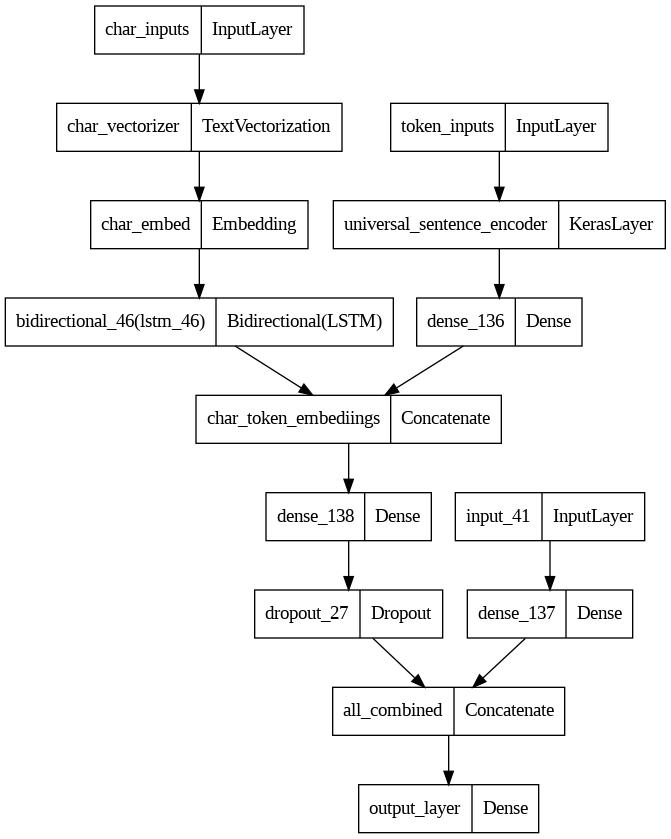

In [199]:
plot_model(model_5)

In [213]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer='adam',
    metrics=['accuracy']
)

In [211]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (
        tf.constant(train_df['engineering'].to_numpy()),
        train_sentences,
        train_chars)
)

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                    train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




val_char_token_pos_data = tf.data.Dataset.from_tensor_slices(
    (
        tf.constant(val_df['engineering'].to_numpy()),
        val_sentences,
        val_chars)
)

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                    val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [214]:
model_5.fit(
    train_char_token_pos_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
    validation_data = val_char_token_pos_dataset,
    validation_steps = int(0.1*len(val_char_token_pos_dataset))
)

Epoch 1/3
562/562 [==============================] - 135s 227ms/step - loss: 1.0988 - accuracy: 0.7200 - val_loss: 0.9837 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 129s 230ms/step - loss: 0.9786 - accuracy: 0.8088 - val_loss: 0.9479 - val_accuracy: 0.8324
Epoch 3/3
562/562 [==============================] - 122s 217ms/step - loss: 0.9594 - accuracy: 0.8191 - val_loss: 0.9331 - val_accuracy: 0.8467


In [216]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 58s 59ms/step


array([[0.5726099 , 0.03865716, 0.04619849, 0.32285976, 0.0196746 ],
       [0.6388221 , 0.03409677, 0.07564546, 0.23898359, 0.01245216],
       [0.3393565 , 0.0794737 , 0.14706339, 0.3582313 , 0.07587515],
       ...,
       [0.02237432, 0.09780094, 0.03067616, 0.02417252, 0.82497615],
       [0.0161736 , 0.30586597, 0.04845769, 0.01714401, 0.61235875],
       [0.23354195, 0.52916443, 0.10011067, 0.0512827 , 0.08590031]],
      dtype=float32)

In [217]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [218]:

# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.44366476896597,
 'precision': 0.8331638218783177,
 'recall': 0.8344366476896597,
 'f1': 0.8327933183775258}

In [219]:
model_5.save('skimlit_model')

In [220]:
loaded_model = tf.keras.models.load_model('skimlit_model')

In [222]:
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset, verbose=1)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_preds[:10]


945/945 [==============================] - 61s 59ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [223]:
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.44366476896597,
 'precision': 0.8331638218783177,
 'recall': 0.8344366476896597,
 'f1': 0.8327933183775258}